In [2]:
import numpy as np
import pandas as pd 

import os


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

In [1]:
!pip install python-mnist

In [7]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

# Custom Dataset class to handle the data
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype('float32').reshape(28, 28) / 255.0
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values
y = mnist.target.astype(int).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

trainset = MNISTDataset(X_train, y_train, transform=transform)
valset = MNISTDataset(X_val, y_val, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

for images, labels in trainloader:
    print(images.shape, labels.shape)
    break


## Creating kolmogorov arnold network

In [4]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Initialization of network

Input Layer is 784 i.e. 28 x 28 which is dimension of image <br>
Hidden layer is 2 x input_layer+1 i.e. 1569 <br>
Output layer is 10 for all digits

In [5]:
# Define model
model = KAN([28 * 28, 28 * 28 * 2 + 1, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

KAN(
  (layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): SiLU()
    )
  )
)

Defining Optimizer and Learning Rate Decay

In [6]:
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)



In [7]:
# Define loss
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


## training of Network

In [8]:
for epoch in range(20):
    # Train
    model.train()
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels).float().mean()
            epoch_train_loss += loss.item()
            epoch_train_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    epoch_train_loss /= len(trainloader)
    epoch_train_accuracy /= len(trainloader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.argmax(dim=1).cpu().numpy())

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")


100%|██████████| 525/525 [00:08<00:00, 63.66it/s, accuracy=0.922, loss=0.182, lr=0.001]


Epoch 1, Train Loss: 0.32951514990556807, Train Accuracy: 0.9004761904761904, Val Loss: 0.17857003892122797, Val Accuracy: 0.9447206439393939


100%|██████████| 525/525 [00:07<00:00, 66.75it/s, accuracy=0.969, loss=0.181, lr=0.0008]


Epoch 2, Train Loss: 0.11409986420401505, Train Accuracy: 0.9658630952380952, Val Loss: 0.13168412008125222, Val Accuracy: 0.9578598484848485


100%|██████████| 525/525 [00:08<00:00, 65.27it/s, accuracy=0.984, loss=0.0637, lr=0.00064]


Epoch 3, Train Loss: 0.05950978647651417, Train Accuracy: 0.9822619047619048, Val Loss: 0.10115350895053284, Val Accuracy: 0.9682765151515151


100%|██████████| 525/525 [00:07<00:00, 66.76it/s, accuracy=1, loss=0.0173, lr=0.000512]


Epoch 4, Train Loss: 0.02946298257935615, Train Accuracy: 0.9922321428571429, Val Loss: 0.08093627665728105, Val Accuracy: 0.9739583333333334


100%|██████████| 525/525 [00:07<00:00, 67.04it/s, accuracy=1, loss=0.0371, lr=0.00041]


Epoch 5, Train Loss: 0.014153277100108209, Train Accuracy: 0.9972321428571429, Val Loss: 0.07400593431807603, Val Accuracy: 0.9777462121212122


100%|██████████| 525/525 [00:07<00:00, 66.66it/s, accuracy=0.984, loss=0.0197, lr=0.000328]


Epoch 6, Train Loss: 0.006878736254736959, Train Accuracy: 0.9992261904761904, Val Loss: 0.07509145286343427, Val Accuracy: 0.9781013257575758


100%|██████████| 525/525 [00:07<00:00, 66.10it/s, accuracy=1, loss=0.00667, lr=0.000262]


Epoch 7, Train Loss: 0.00364966310095042, Train Accuracy: 0.9997916666666666, Val Loss: 0.07415443119261357, Val Accuracy: 0.9777462121212122


100%|██████████| 525/525 [00:07<00:00, 65.87it/s, accuracy=1, loss=0.00157, lr=0.00021]


Epoch 8, Train Loss: 0.0022992174486474444, Train Accuracy: 1.0, Val Loss: 0.0737676416492005, Val Accuracy: 0.9779829545454546


100%|██████████| 525/525 [00:07<00:00, 66.13it/s, accuracy=1, loss=0.00162, lr=0.000168]


Epoch 9, Train Loss: 0.0016908568507503895, Train Accuracy: 1.0, Val Loss: 0.07369936380189646, Val Accuracy: 0.9785748106060606


100%|██████████| 525/525 [00:08<00:00, 65.59it/s, accuracy=1, loss=0.00162, lr=0.000134]


Epoch 10, Train Loss: 0.001350673335116534, Train Accuracy: 1.0, Val Loss: 0.07439234314105389, Val Accuracy: 0.9779829545454546


100%|██████████| 525/525 [00:07<00:00, 65.65it/s, accuracy=1, loss=0.000867, lr=0.000107]


Epoch 11, Train Loss: 0.001118436781938986, Train Accuracy: 1.0, Val Loss: 0.07512654856492934, Val Accuracy: 0.978219696969697


100%|██████████| 525/525 [00:08<00:00, 65.46it/s, accuracy=1, loss=0.00103, lr=8.59e-5]


Epoch 12, Train Loss: 0.0009633249910118701, Train Accuracy: 1.0, Val Loss: 0.07514311688701679, Val Accuracy: 0.9779829545454546


100%|██████████| 525/525 [00:07<00:00, 66.87it/s, accuracy=1, loss=0.000366, lr=6.87e-5]


Epoch 13, Train Loss: 0.0008404493631124274, Train Accuracy: 1.0, Val Loss: 0.07633149180875273, Val Accuracy: 0.978219696969697


100%|██████████| 525/525 [00:08<00:00, 65.48it/s, accuracy=1, loss=0.000356, lr=5.5e-5]


Epoch 14, Train Loss: 0.0007378138796359832, Train Accuracy: 1.0, Val Loss: 0.07534625637874176, Val Accuracy: 0.978219696969697


100%|██████████| 525/525 [00:07<00:00, 66.60it/s, accuracy=1, loss=0.000428, lr=4.4e-5]


Epoch 15, Train Loss: 0.0006586070999730423, Train Accuracy: 1.0, Val Loss: 0.07564514053008294, Val Accuracy: 0.978811553030303


100%|██████████| 525/525 [00:07<00:00, 66.81it/s, accuracy=1, loss=0.000334, lr=3.52e-5]


Epoch 16, Train Loss: 0.0005966180438346263, Train Accuracy: 1.0, Val Loss: 0.07639564925480183, Val Accuracy: 0.9784564393939394


100%|██████████| 525/525 [00:07<00:00, 65.74it/s, accuracy=1, loss=0.000456, lr=2.81e-5]


Epoch 17, Train Loss: 0.0005398993124669817, Train Accuracy: 1.0, Val Loss: 0.07673318102200882, Val Accuracy: 0.978811553030303


100%|██████████| 525/525 [00:07<00:00, 66.59it/s, accuracy=1, loss=0.000422, lr=2.25e-5]


Epoch 18, Train Loss: 0.0004944171893571149, Train Accuracy: 1.0, Val Loss: 0.07680962893716765, Val Accuracy: 0.9785748106060606


100%|██████████| 525/525 [00:07<00:00, 67.55it/s, accuracy=1, loss=0.000465, lr=1.8e-5]


Epoch 19, Train Loss: 0.00045788528450343405, Train Accuracy: 1.0, Val Loss: 0.07734795830214297, Val Accuracy: 0.9784564393939394


100%|██████████| 525/525 [00:07<00:00, 67.85it/s, accuracy=1, loss=0.000346, lr=1.44e-5]


Epoch 20, Train Loss: 0.00042611572194367733, Train Accuracy: 1.0, Val Loss: 0.07753022726330638, Val Accuracy: 0.978811553030303


## training Plot of Network

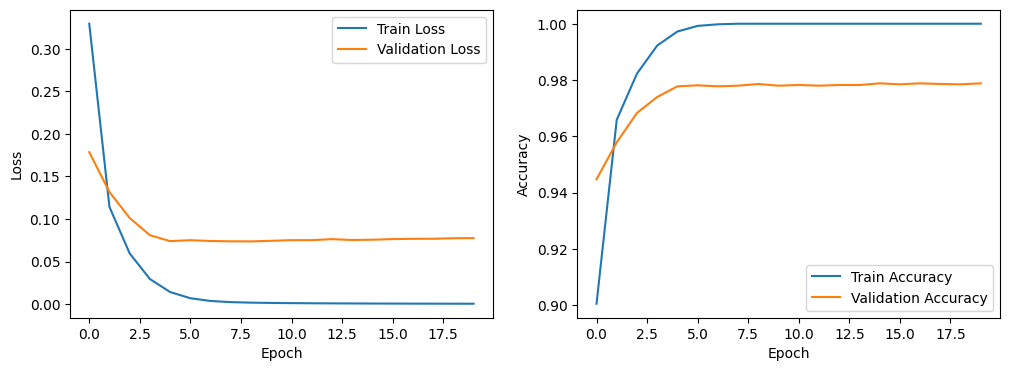

In [9]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



## Confusion Matrix Plot

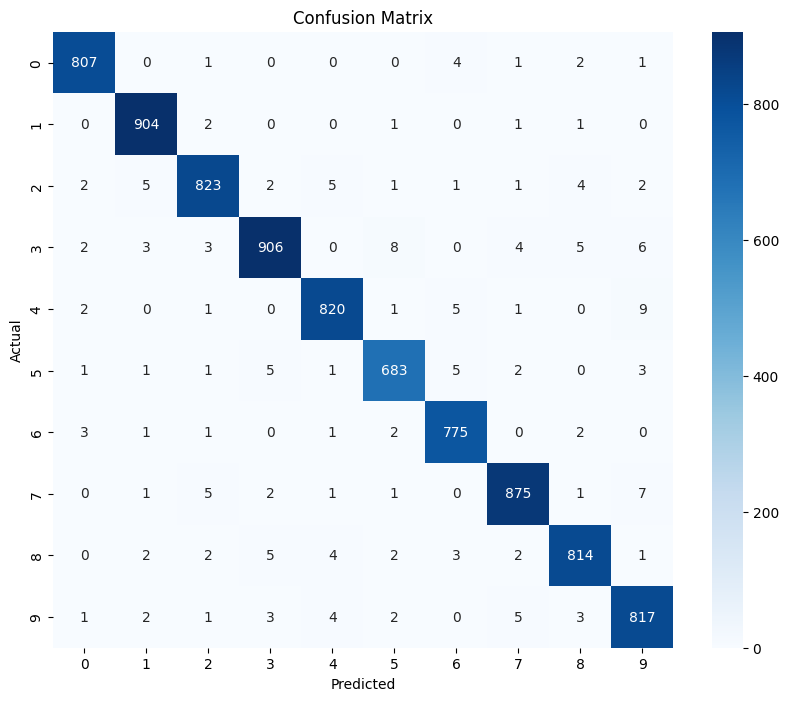

In [10]:
import numpy as np

# Define class labels
class_labels = np.arange(10)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
